# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64  # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [2]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    # Подготовка и загрузка тестовых данных (без перемешивания)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Загрузка тестовых данных (с перемешиванием)
    test_loader_shuffle = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader, test_loader, test_loader_shuffle

In [3]:
# Загрузка тренировочных и тестовых данных

train_loader, test_loader, test_loader_shuffle = load_dataloaders()
print('')
print('Количество батчей в train_loader и test_loader:', len(train_loader), 'и', len(test_loader))

100%|██████████| 170498071/170498071 [00:03<00:00, 46741573.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Количество батчей в train_loader и test_loader: 782 и 157


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [4]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    img = torchvision.utils.make_grid(images)
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

        bird             horse             frog             deer


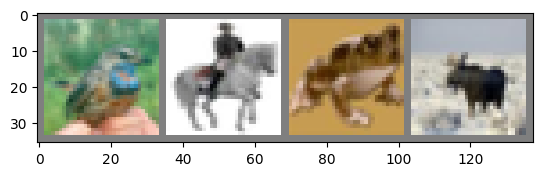

In [5]:
# https://habr.com/ru/articles/478208/
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


dataiter = iter(test_loader_shuffle) # Создаем итератор из тестовых данных
images, labels = next(dataiter) # Получаем батч изображений и их меток

imshow(images[0:4], labels[0:4], labels_split_size=13, padding_size=8) # отображаем первые 4 изображения из батча

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [6]:
# https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/

nn.Conv2d: These are the convolutional layers that accepts the number of input and output channels as arguments, along with kernel size for the filter. It also accepts any strides or padding if we want to apply those

nn.BatchNorm2d: This applies batch normalization to the output from the convolutional layer

nn.ReLU: This is a type of  activation function applied to various outputs in the network

In [7]:
import torch.nn as nn

class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        # Первый сверточный слой (1x1 ядро)
        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential(  # Residual Block
            nn.Conv2d(3, 32, 3, padding=1),        # Сверточный слой с ядром 3x3
            nn.BatchNorm2d(32),                    # Нормализация батча
            nn.ReLU(),                             # Функция активации
            nn.Conv2d(32, 32, 3, padding=1),       # Второй сверточный слой с ядром 3x3
            nn.BatchNorm2d(32)                     # Нормализация батча
        )

        # Классификационный слой
        self.clf = nn.Sequential(
            nn.ReLU(),                             # Функция активации
            nn.AvgPool2d(8),                       # Усреднение значений
            nn.Flatten(1),                         # Перевод в одномерный вектор
            nn.Linear(512, n_classes)              # Полносвязный слой для классификации
        )

    def forward(self, x):
        # Проход через Residual Block и добавление результата к оригинальному входу
        out = self.residual_block(x)
        out += self.conv_3(x)

        # Проход через классификационный слой
        out = self.clf(out)

        return out

In [8]:
# Создание экземпляра нейронной сети ResidualNet
net = ResidualNet()

In [9]:
# Проверка
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [10]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        # Инициализация тренера сети.
        # model: модель нейронной сети
        # optimizer: оптимизатор для обновления весов сети
        # criterion: функция потерь для оценки ошибки
        self.model = model
        # Определение устройства (GPU или CPU) для обучения сети.
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # Перемещение модели на определенное устройство.
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        # Обучение модели на одной эпохе (полный проход по данным обучения).
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        # Обучение модели на протяжении заданного количества эпох.
        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")

    def test(self, test_loader):
        # Оценка производительности модели на данных тестирования.
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [11]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4)) # 1 строка и 2 столбца для двух графиков

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [12]:
# import torch.optim

criterion = nn.CrossEntropyLoss() # выбираем функцию ошибок (кросс-энтропийная функция ошибок)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9) # выбираем оптимизатор (стохастический градиентный спуск (SGD))

# Создаем объект класса Trainer, передавая модель, оптимизатор и функцию ошибки для обучения.
trainer = Trainer(net, optimizer, criterion)

Сеть загружена на cpu


In [13]:
trainer.train(train_loader, test_loader, n_epochs=5) #обучаю

Epoch 0
 train loss: 90.84751319885254, train acc: 0.49556425831202044
 test loss: 88.73368705457942, test acc: 0.5305533439490446

Epoch 1
 train loss: 70.74180908886063, train acc: 0.6164082480818415
 test loss: 68.59814126324501, test acc: 0.6227109872611465

Epoch 2
 train loss: 64.92782556431372, train acc: 0.6469789002557544
 test loss: 66.1407499981534, test acc: 0.6327627388535032

Epoch 3
 train loss: 61.83400288262331, train acc: 0.663503037084399
 test loss: 64.58169771911233, test acc: 0.648984872611465

Epoch 4
 train loss: 59.07906822780209, train acc: 0.6804267902813299
 test loss: 60.659179972994856, test acc: 0.6674960191082803



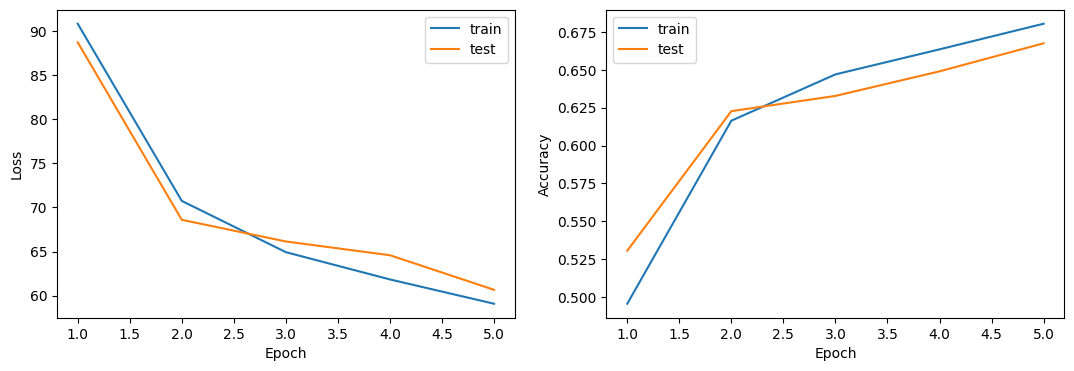

In [14]:
plot_train_log(trainer) #визуализирую процесс обучения

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [15]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [16]:
transform_v2 = transforms.Compose(
        [
            transforms.RandomGrayscale(p=0.3),
            # transforms.ColorJitter(brightness=0.8, hue=0.1, contrast=0.9),
            transforms.RandomHorizontalFlip(p=0.5),

            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)

In [17]:
train_loader_2, test_loader_2, test_loader_shuffle_2 = load_dataloaders(transform=transform_v2, batch_size=BATCH_SIZE)

trainer_2 = Trainer(net, optimizer, criterion) # присваиваю класс, параметры из таск 1.4

Files already downloaded and verified
Files already downloaded and verified
Сеть загружена на cpu


In [18]:
trainer_2.train(train_loader_2, test_loader_2, n_epochs=5)

Epoch 0
 train loss: 62.44347474398211, train acc: 0.6624640345268542
 test loss: 61.189163821518044, test acc: 0.6690883757961783

Epoch 1
 train loss: 60.2156923091625, train acc: 0.6765105498721228
 test loss: 61.50498354359038, test acc: 0.6643113057324841

Epoch 2
 train loss: 58.95508267019716, train acc: 0.6802869245524297
 test loss: 60.26490962884988, test acc: 0.6759554140127388

Epoch 3
 train loss: 57.85275421362094, train acc: 0.6868406329923273
 test loss: 63.114130627577474, test acc: 0.662718949044586

Epoch 4
 train loss: 56.93180778630249, train acc: 0.692335358056266
 test loss: 63.05621883975473, test acc: 0.6610270700636943



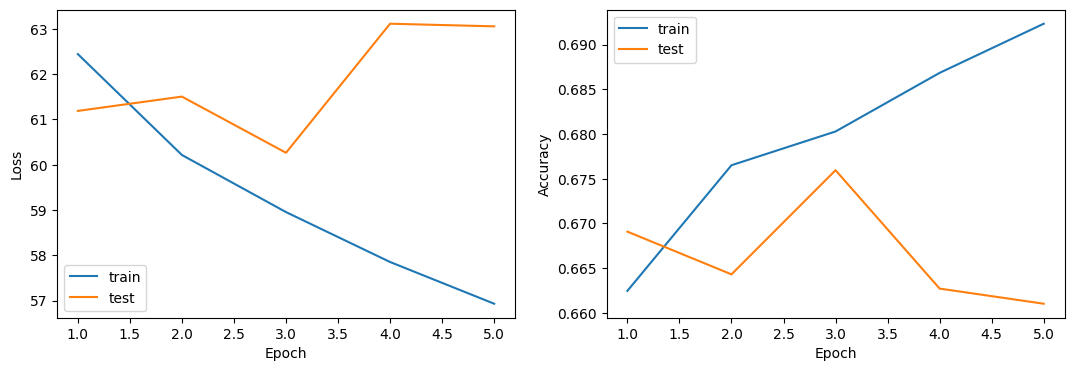

In [19]:
plot_train_log(trainer_2) #визуализирую

        cat             ship             ship             plane


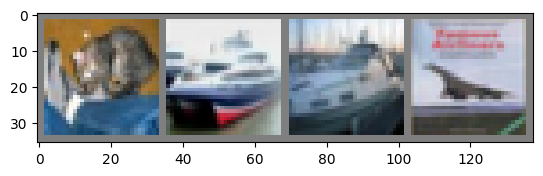

        cat             ship             ship             plane


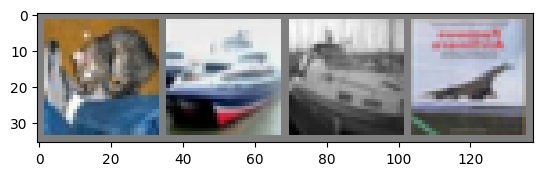

In [20]:
# исходные картинки

dataiter_1 = iter(test_loader)
images_1, labels_1 = next(dataiter_1)

imshow(images_1[0:4], labels_1[0:4], labels_split_size=13, padding_size=8)

# аугментированные картинки

dataiter_2 = iter(test_loader_2)
images_2, labels_2 = next(dataiter_2)

imshow(images_2[0:4], labels_2[0:4], labels_split_size=13, padding_size=8)